In [25]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm

from moral_foundations_llms.analysis import cochran_armitage_trend_test
from mpl_lego.labels import apply_subplot_labels

from functools import partial
from mpl_lego.labels import bold_text
from scipy.stats import bootstrap
from pyprojroot import here
 
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 0)

In [3]:
mplego.style.use_latex_style()

In [4]:
df = pd.read_csv(here('data/aita_final_v14.csv'))

/var/folders/6h/ms_dpkl536d1w6qqd_wnckrw0000gn/T/ipykernel_98486/2197173451.py:1: DtypeWarning: Columns (29,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(here('data/aita_final_v14.csv'))


In [5]:
MODELS = [
    'reddit',
    'gpt3.5',
    'gpt4',
    'claude',
    'bison',
    'gemma',
    'mistral',
    'llama']
n_models = len(MODELS)
MORAL_AXES = [
    'fairness',
    'feelings',
    'harms',
    'honesty',
    'relational_obligation',
    'social_norms']
n_morals = len(MORAL_AXES)

REASON_COLS = [
    'top_comment',
    'gpt3.5_reason_1',
    'gpt4_reason_1',
    'claude_reason_1',
    'bison_reason_1',
    'gemma_reason_1',
    'mistral_reason_1',
    'llama_reason_1']
models_to_reasons = dict(zip(MODELS, REASON_COLS))

LABEL_COLS = [
    'reddit_label',
    'gpt3.5_label_1',
    'gpt4_label_1',
    'claude_label_1',
    'bison_label_1',
    'gemma_label_1',
    'mistral_label_1',
    'llama_label_1']
models_to_labels = dict(zip(MODELS, LABEL_COLS))

model_print_labels = ['Redditor',
                'GPT 3.5',
                'GPT 4',
                'Claude Sonnet',
                'Bison',
                'Gemma 7B',
                'Mistral 7B',
                'Llama 2 7B']
moral_axis_print_labels = [
    'Fairness',
    'Feelings',
    'Harms',
    'Honesty',
    'Relational Obligation',
    'Social Norms']

all_probs = [[f'{reason}_{moral}_prob'
              for moral in MORAL_AXES]
             for reason in REASON_COLS]

In [6]:
for (model, label_col), probs in zip(models_to_labels.items(), all_probs):
    df[f'{model}_n_themes'] = (df[probs] > 0.5).sum(axis=1)

In [7]:
def YTA_vs_n_themes(df, model):
    LABEL_COL = models_to_labels[model]
    return df.groupby(f'{model}_n_themes').apply(
        lambda x: (x[LABEL_COL] == 'YTA').mean()
    ).reset_index(name=f'{model}_YTA_fraction', drop=True)

In [8]:
def YTA_vs_n_themes_bootstrap(records, model, n_themes):
    LABEL_COL = models_to_labels[model]
    labels = records[LABEL_COL]
    sub = labels[records[f'{model}_n_themes'] == n_themes]
    if sub.size == 0:
        return 0
    return (sub == 'YTA').mean()

In [9]:
means = [YTA_vs_n_themes(df, model) for model in MODELS]

In [10]:
bootstraps = [[bootstrap((df[[models_to_labels[model], f'{model}_n_themes']].to_records(index=False),),
                        partial(YTA_vs_n_themes_bootstrap, model=model, n_themes=idx))
              for idx in range(6)]
              for model in MODELS]

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the stati

In [16]:
for model in MODELS:
    contingency_table = np.array([
        df.groupby(f'{model}_n_themes').apply(
            lambda x: (x[models_to_labels[model]] == 'YTA').sum()
        ).reset_index(name=f'{model}_YTA_fraction', drop=True).values,
        df.groupby(f'{model}_n_themes').apply(
            lambda x: (x[models_to_labels[model]] != 'YTA').sum()
        ).reset_index(name=f'{model}_YTA_fraction', drop=True).values]).T[1:-1]
    print(model, cochran_armitage_trend_test(contingency_table, np.arange(4)))

reddit (7.359717148361162, 1.8429702208777599e-13)
gpt3.5 (2.7604354737623984, 0.005772435983506963)
gpt4 (1.5957928896536342, 0.11053504131307212)
claude (8.143558102733317, 4.440892098500626e-16)
bison (4.7074888120628335, 2.5078704044556588e-06)
gemma (1.9931171184720764, 0.04624862391586859)
mistral (4.018020839987804, 5.868900773831065e-05)
llama (-1.041716547965601, 0.2975431145784233)


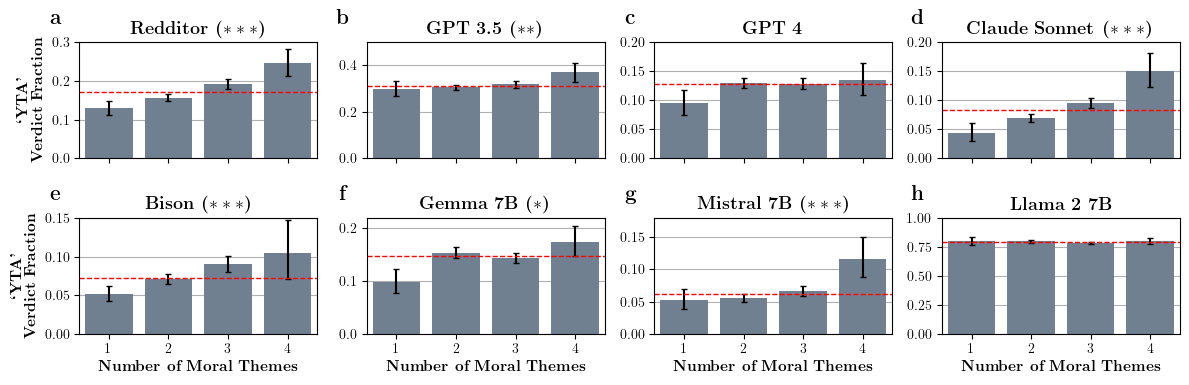

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(12, 4), sharex=True)
sigs = [r' ($\ast \ast \ast$)', r' ($\ast \ast$)', '', r' ($\ast \ast \ast$)', r' ($\ast \ast \ast$)', r' ($\ast$)', r' ($\ast \ast \ast$)', '']

for idx, (ax, vals, mean, sig) in enumerate(zip(axes.ravel(), bootstraps, means, sigs)):
    
    uppers = [bootstrap.confidence_interval.high for bootstrap in vals]
    lowers = [bootstrap.confidence_interval.low for bootstrap in vals]

    ax.bar(np.arange(6),
           mean.values,
           color='slategray',
           yerr=[[mean - lower for lower, mean in zip(lowers, mean.values)],
                 [upper - mean for upper, mean in zip(uppers, mean.values)]],
           capsize=2)

    ax.axhline((df[LABEL_COLS[idx]] == 'YTA').mean(), color='red', linestyle='--', lw=1)
    ax.set_title(bold_text(model_print_labels[idx] + sig), fontsize=13)
    ax.set_xticks(np.arange(6))

    ax.set_xlim([0.5, 4.5])
    ax.grid(axis='y')
    
    ax.set_axisbelow(True)

axes[0, 0].set_ylim(top=0.3)
axes[0, 1].set_ylim(top=0.5)
axes[0, 2].set_ylim(top=0.2)
axes[0, 3].set_ylim(top=0.2)
axes[1, 0].set_ylim(top=0.15)
axes[1, 1].set_ylim(top=0.22)
axes[1, 2].set_ylim(top=0.18)
axes[1, 3].set_ylim(top=1)

for ax in axes[1]:
    ax.set_xlabel(bold_text('Number of Moral Themes'), fontsize=11)

for ax in axes[:, 0]:
    ax.set_ylabel(bold_text("`YTA'\nVerdict Fraction"), fontsize=11)
    
apply_subplot_labels(axes, bold=True, x=-0.10, y=1.2)

plt.tight_layout()
plt.savefig('yta_vs_reasons.pdf', bbox_inches='tight')